# Using the DearEIS API

The API documentation can be found [here](https://vyrjana.github.io/DearEIS/api/).

## Getting started

The API can be imported conveniently as follows:

In [1]:
import deareis

The API provides access to functions like `parse_data`, `perform_test`, and `fit_circuit_to_data`.
Many of these functions are wrappers for similar functions found in the pyimpspec package, which DearEIS is based on.
However, it should be noted that the function signatures may differ somewhat (e.g., the number of arguments, the argument types, the return type).
Check out the API documentation for further information.

The API includes some functions for basic visualization using matplotlib.
For the sake of convenience, it will be imported as follows for use throughout the rest of this notebook:

In [2]:
from deareis import mpl

Below is a an example of how one might prepare a JupyterLab notebook for plots.

In [3]:
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = [12, 6]

Some specific classes will also be imported for the purposes of adding type annotations throughout the notebook:

In [4]:
from deareis import (
    DataSet,
    FitResult,
    Project,
    PlotSeries,
    PlotSettings,   
    SimulationResult,
    TestResult,
)
from matplotlib.figure import Figure
from numpy import ndarray
from typing import List, Optional

## Examples of use cases

DearEIS is primarily intended to be used via the graphical user interface (GUI).
However, the GUI and the API can be combined to implement hybrid workflows that make use of the strengths of both approaches when performing specific tasks.

### Example 1

Let's say that we are working on a thesis or an article that is going to be typeset using LaTeX.
We would like to include results that have been obtained by characterizing some samples using electrochemical impedance spectroscopy (EIS).
The experimental data is imported into a DearEIS project and the following work has been done in the GUI program:

- A few outliers have been excluded.
- The data has been validated using Kramers-Kronig analysis.
- Suitable equivalent circuits have been developed and fitted to the data.
- Plots that compare multiple spectra have been composed.

The GUI program does include the functionality required for copying the results as character-separated values (CSV) so that tables and plots could be prepared using, e.g., a spreadsheet program.
However, an advantage of using the API instead is that if, e.g., style changes needed to be made, then the tables and/or figures could be updated simply by executing the relevant scripts again.
The API could be used to:

- Generate plots as vector graphics using, e.g., [matplotlib](https://matplotlib.org/) or another plotting library.
- Generate LaTeX tables (or, e.g., Markdown tables if [Pandoc](https://pandoc.org/) is used) containing the results of circuit fits.
- Generate the code needed to draw circuit diagrams using the [CircuiTikZ package](https://ctan.org/pkg/circuitikz).

These scripts could even be included in a build system that used, e.g., a Docker image to provide a reproducible environment for generating a PDF from the source files (LaTeX files, figures, etc.).

#### Loading a project

Existing projects can be loaded using the `Project.from_file` method.

In [5]:
project_ex1: Project = Project.from_file("example-project.json")

#### Generating plots

##### Data sets

Individual data sets could be plotted as follows:

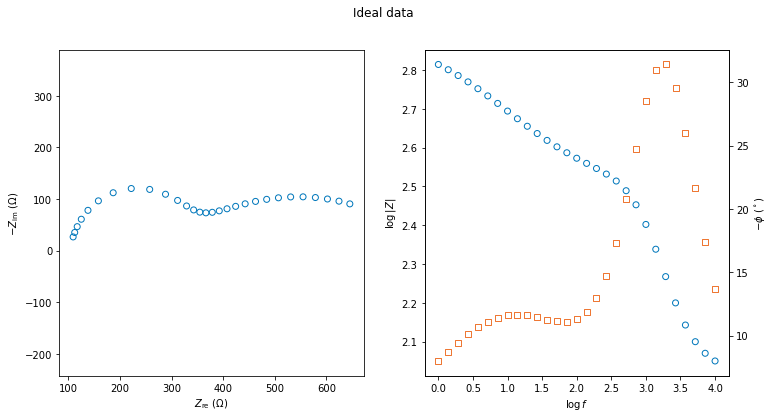

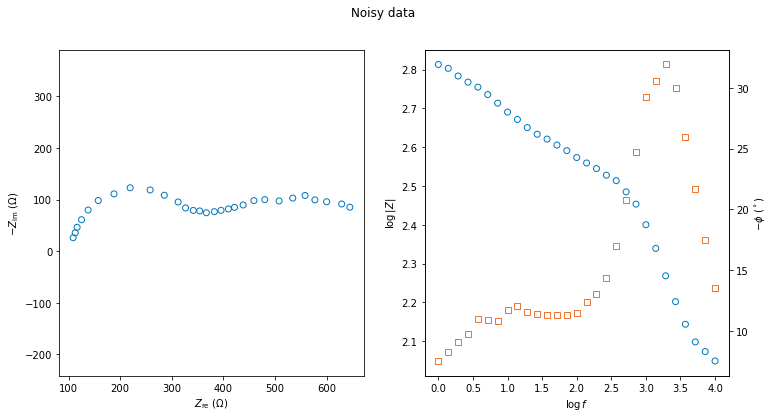

In [6]:
data: DataSet
for data in project_ex1.get_data_sets():
    fig, axes = mpl.plot_data(data)
    
    # Alternatively, the required data can be accessed as follows for use with another plotting library.
    # - Raw data
    f: ndarray = data.get_frequency()
    Z: ndarray = data.get_impedance()
    
    # - Data for a Nyquist plot (re = Z.real, im = -Z.imag)
    re: ndarray
    im: ndarray
    real, imag = data.get_nyquist_data()
    
    # - Data for a Bode plot (log_f = log10(f), log_mag = log10(abs(Z)), log_phi = -numpy.angle(Z, deg=True))
    log_f: ndarray
    log_mag: ndarray
    log_phi: ndarray
    log_f, log_mag, log_phi = data.get_bode_data()

The `plot_data` function uses the `plot_nyquist` and `plot_bode` functions but those can also be used directly:

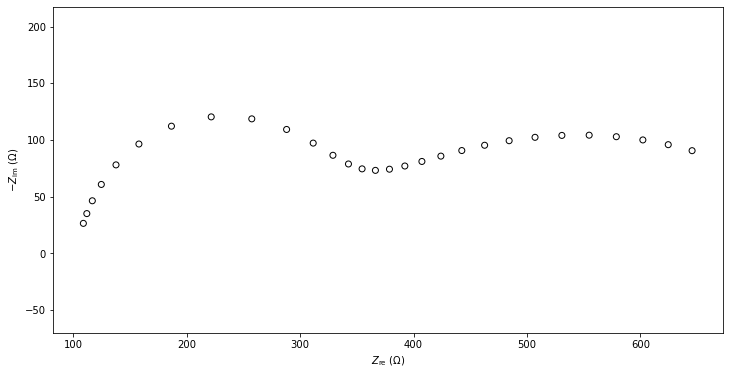

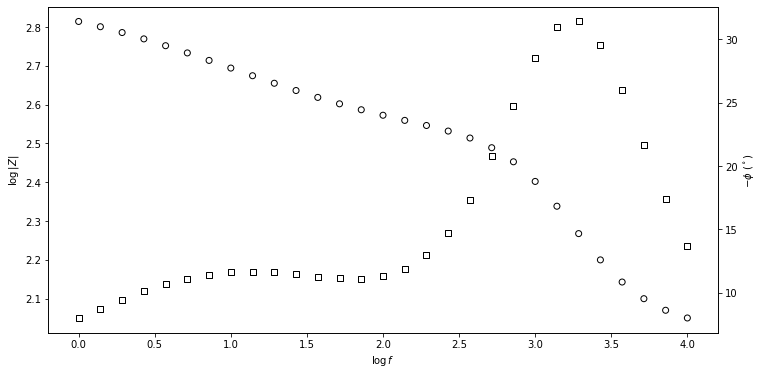

In [7]:
data: DataSet = project_ex1.get_data_sets()[0]
fig, axes = mpl.plot_nyquist(data)
fig, axes = mpl.plot_bode(data)

##### Kramers-Kronig test results

Similarly, Kramers-Kronig test results and circuit fit results can also be accessed and plotted:

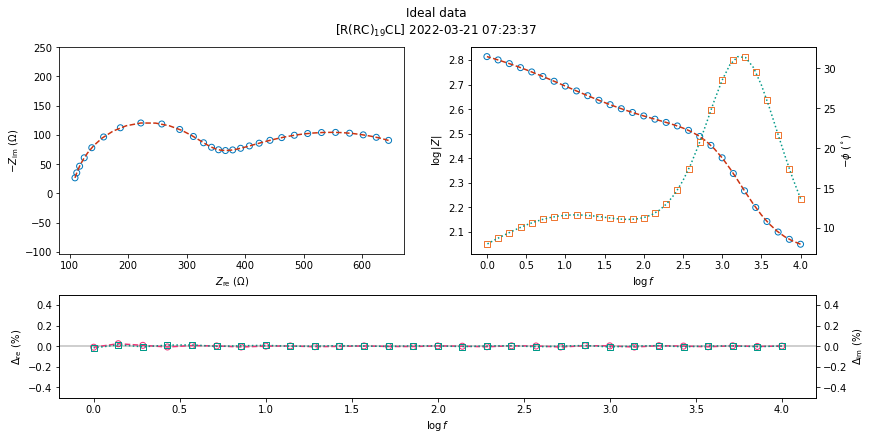

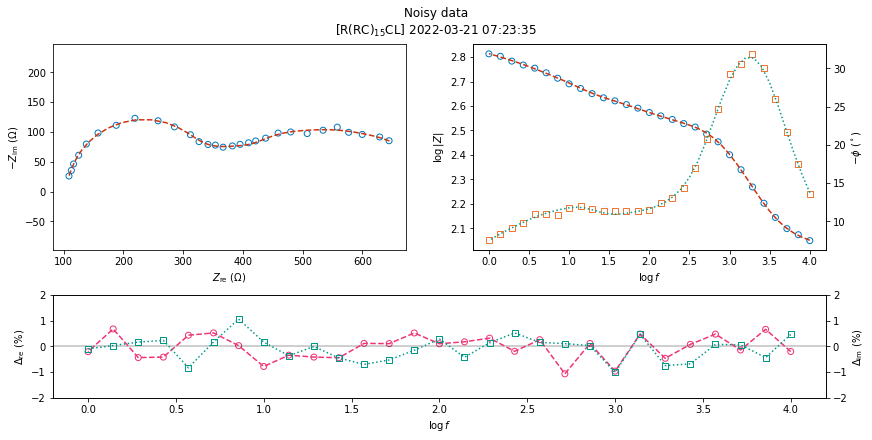

In [8]:
data: DataSet
for data in project_ex1.get_data_sets():
    test: TestResult
    for test in project_ex1.get_tests(data):  # Get the test results for a specific data set.
        fig, axes = mpl.plot_fit(test, data, num_per_decade=10)  # The number of points per decade used when plotting lines can be changed.
        
        # The raw data and plot-specific data can be obtained with TestResult objects as was shown earlier with the DataSet objects.
        f: ndarray = test.get_frequency()
        Z: ndarray = test.get_impedance()
        
        # The number of points can also be increased here to achieve smoother lines.
        f = test.get_frequency(num_per_decade=100)
        Z = test.get_impedance(num_per_decade=100)

##### Circuit fit results

Circuit fit results can be plotted in the same way as Kramers-Kronig test results.

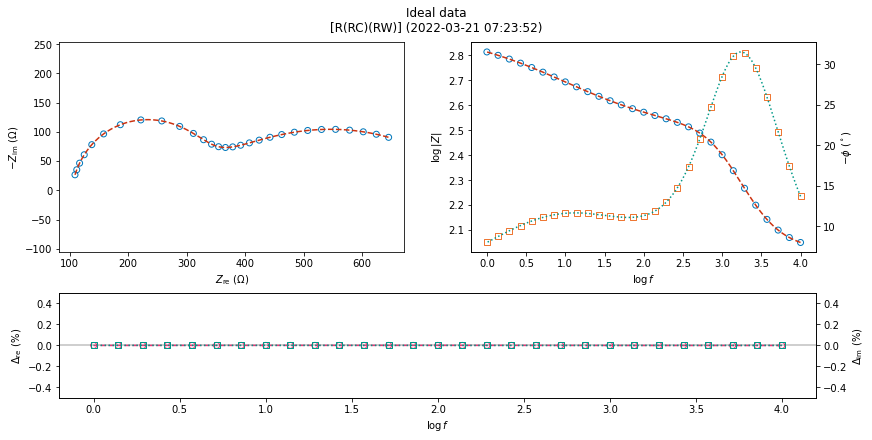

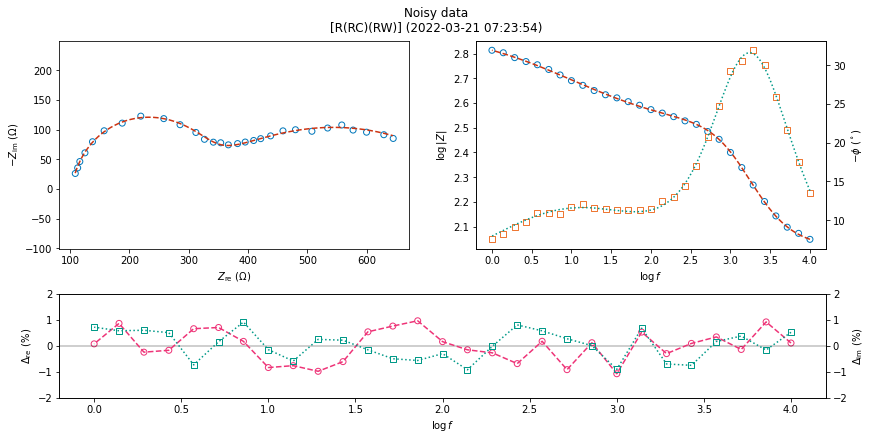

In [9]:
data: DataSet
for data in project_ex1.get_data_sets():
    fit: FitResult
    for fit in project_ex1.get_fits(data):  # Get the fit results for a specific data set.
        fig, axes = mpl.plot_fit(fit, data)
        
        # The raw data and plot-specific data can also be obtain with FitResult objects (see the previous cell).
        re: ndarray
        im: ndarray
        real, imag = fit.get_nyquist_data(num_per_decade=25)

##### Simulation results

Simulations can also be accessed and plotted easily:

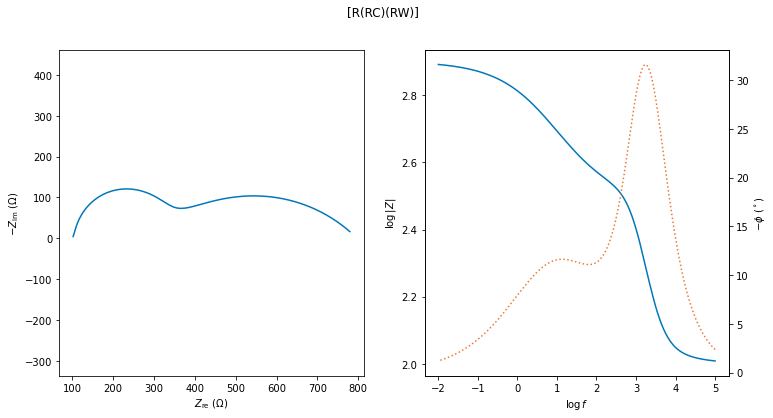

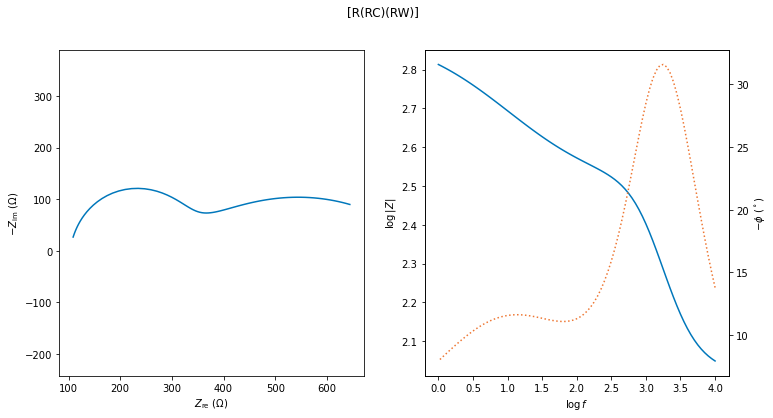

In [10]:
sim: SimulationResult
for sim in project_ex1.get_simulations():
    fig, axes = mpl.plot_circuit(sim.circuit, sim.get_frequency(num_per_decade=20))

##### Composed plots

Plots composed in the GUI program (`Plotting` tab) for the purposes of, e.g., comparing different results can be plotted as follows using the provided function:

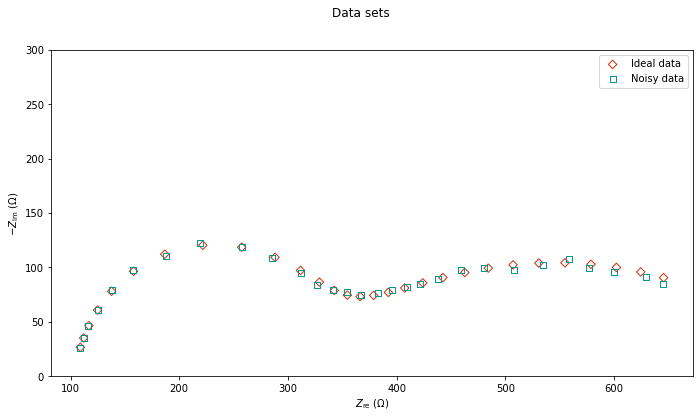

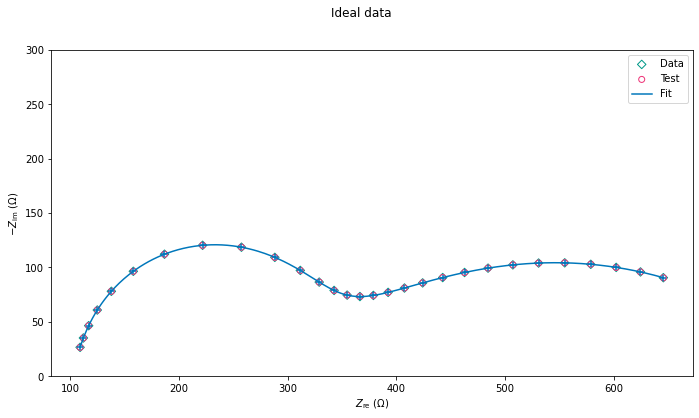

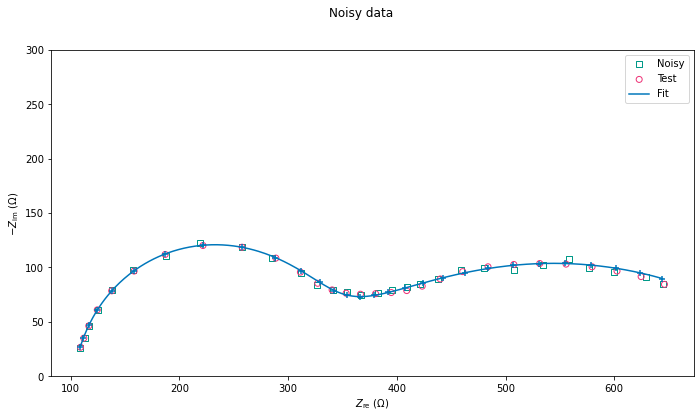

In [11]:
settings: PlotSettings
for settings in project_ex1.get_plots():
    if "template" in settings.get_label().lower():
        # Skipping the plot that was used simply as a template for defining the styles
        # (markers, colors, etc.) so that the styles could be copied to other plots.
        continue
    fig, axis = mpl.plot(settings, project_ex1, y_limits=(0, 300,))

##### Custom composed plots

The dictionary `deareis.mpl.MPL_MARKERS` can be used to look up matplotlib's equivalent string representation for similar markers.
If you are using a plotting library that is not currently supported, then you can compare the return value of `series.get_marker()` against _DearPyGui_'s `mvPlotMarker_*` constants and figure out the appropriate value for your plotting library of choice.

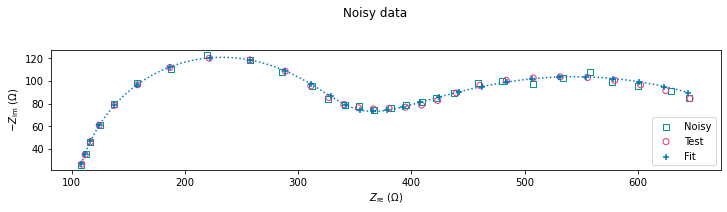

In [12]:
# Prepare the figure that will be used to create a custom Nyquist plot
fig = Figure(figsize=(12,3))
ax = fig.gca()

# Get the settings for the composed plot that contains the series (data sets, fit results, etc.) that we wish to plot.
settings = list(filter(lambda s: s.get_label() == "Noisy data", project_ex1.get_plots()))[0]

# Each data set, fit result, etc. can be represented as a PlotSeries object that contains the required data and the style (color, marker, etc.).
series: PlotSeries
for series in project_ex1.get_plot_series(settings, num_per_decade=50):
    # Figure out if the series should be included in the figure legend.
    label: Optional[str] = None
    if series.has_legend():
        label = series.get_label()
    
    # Figure out the color and marker.
    color: List[float] = series.get_color()
    marker: Optional[str] = mpl.MPL_MARKERS.get(series.get_marker())
    
    # Determine whether or not the series should be plotted using markers, a line, or both.
    if series.has_line():
        ax.plot(*series.get_line_data(), color=color, linestyle=":", label=label if marker is None else None)
        if marker is not None:
            ax.scatter(*series.get_scatter_data(), color=color, marker=marker, label=label)
    elif marker is not None:
        ax.scatter(*series.get_scatter_data(), edgecolor=color, facecolor="None", marker=marker, label=label)

# Add the figure title and legend.
fig.suptitle(settings.get_label())
ax.legend()

# Set the correct aspect ratio and axis labels for a Nyquist plot.
ax.set_aspect("equal")
ax.set_xlabel(r"$Z_{\rm re}\ (\Omega)$")
ax.set_ylabel(r"$-Z_{\rm im}\ (\Omega)$")

# Show the figure.
fig

#### Generating tables

`FitResult` and `SimulationResult` objects have a `to_dataframe` method that returns a `pandas.DataFrame` object, which can be used to generate circuit element parameter tables in various formats.

In [13]:
data: DataSet = project_ex1.get_data_sets()[0]
fit: FitResult = project_ex1.get_fits(data)[0]
print(f"<!-- {fit.get_label()} - Markdown -->")
print(fit.to_dataframe().to_markdown(index=False, floatfmt=".3g"))
print(f"\n% {fit.get_label()} - LaTeX")
print(fit.to_dataframe().to_latex(index=False))
print("\n")

sim: SimulationResult = project_ex1.get_simulations()[0]
print(f"<!-- {sim.get_label()} - Markdown -->")
print(sim.to_dataframe().to_markdown(index=False, floatfmt=".3g"))
print(f"\n% {sim.get_label()} - LaTeX")
print(sim.to_dataframe().to_latex(index=False))
print("\n")

<!-- [R(RC)(RW)] (2022-03-21 07:23:52) - Markdown -->
| Element   | Parameter   |    Value | Std. err. (%)   | Fixed   |
|:----------|:------------|---------:|:----------------|:--------|
| R_0       | R           | 100      | -               | No      |
| R_1       | R           | 200      | -               | No      |
| C_2       | C           |   8e-07  | -               | No      |
| R_3       | R           | 500      | -               | No      |
| W_4       | Y           |   0.0004 | -               | No      |

% [R(RC)(RW)] (2022-03-21 07:23:52) - LaTeX
\begin{tabular}{llrll}
\toprule
Element & Parameter &        Value & Std. err. (\%) & Fixed \\
\midrule
    R\_0 &         R & 1.000009e+02 &             - &    No \\
    R\_1 &         R & 1.999982e+02 &             - &    No \\
    C\_2 &         C & 7.999950e-07 &             - &    No \\
    R\_3 &         R & 5.000095e+02 &             - &    No \\
    W\_4 &         Y & 4.000012e-04 &             - &    No \\
\bottomrule
\

/tmp/ipykernel_24801/1140775511.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(fit.to_dataframe().to_latex(index=False))
/tmp/ipykernel_24801/1140775511.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sim.to_dataframe().to_latex(index=False))


#### Generating circuit diagrams and equations

Each `FitResult` and `SimulationResult` object contains a `pyimpspec.Circuit` object that can be used to output SymPy expressions, LaTeX math equations, and LaTeX code for drawing circuit diagrams.

In [14]:
data: DataSet = project_ex1.get_data_sets()[0]
fit: FitResult = project_ex1.get_fits(data)[0]
print("# SymPy expression")
print(fit.circuit.to_sympy())
print("\n% LaTeX math equation")
print(fit.circuit.to_latex())
print("\n% LaTeX circuit diagram")
print(fit.circuit.to_circuitikz())

# SymPy expression
R_0 + 1/(2*I*pi*C_2*f + 1/R_1) + 1/(sqrt(2)*sqrt(pi)*Y_4*sqrt(I*f) + 1/R_3)

% LaTeX math equation
R_{0} + \frac{1}{2 i \pi C_{2} f + \frac{1}{R_{1}}} + \frac{1}{\sqrt{2} \sqrt{\pi} Y_{4} \sqrt{i f} + \frac{1}{R_{3}}}

% LaTeX circuit diagram
\begin{circuitikz}
	\draw (0,0) node[above]{WE+WS} to[short, o-] (1,0);
	\draw (1.0,0.0) to[R=$R_{\rm 0}$] (3.0,0.0);
	\draw (3.0,-0.0) to[R=$R_{\rm 1}$] (5.0,-0.0);
	\draw (3.0,-1.5) to[capacitor=$C_{\rm 2}$] (5.0,-1.5);
	\draw (3.0,-0.0) to[short] (3.0,-1.5);
	\draw (5.0,-0.0) to[short] (5.0,-1.5);
	\draw (5.0,-0.0) to[R=$R_{\rm 3}$] (7.0,-0.0);
	\draw (5.0,-1.5) to[generic=$W_{\rm 4}$] (7.0,-1.5);
	\draw (5.0,-0.0) to[short] (5.0,-1.5);
	\draw (7.0,-0.0) to[short] (7.0,-1.5);
	\draw (7.0,0) to[short, -o] (8.0,0) node[above]{CE+RE};
\end{circuitikz}


### Example 2

In this example we will have a look at how one would go about batch processing (a large amount of) experimental data into a `Project` object that can be used in the GUI program.

#### Creating a new project

First we need to create a new project.

In [15]:
project_ex2: Project = Project()

#### Parsing data files

Now we can iterate over data files and parse them.
In this case we are only going to load `.csv` files.

In [16]:
from os import walk

files: List[str]
for _, _, files in walk("."):
    files = list(filter(lambda f: f.endswith(".csv"), files))
    break

data_sets: List[DataSet] = []
f: str
for f in files:
    data_sets.extend(deareis.parse_data(f))  # parse_data returns a list since some file formats may contain multiple spectra.

#### Adding data sets to the project

The parsed data sets are added to the project.

In [17]:
data: DataSet
for data in data_sets:
    project_ex2.add_data_set(data)

#### Saving the project

Finally, the project is written to disk so that it can be opened in the GUI program.

In [18]:
project_ex2.save("./example-2.json")

### Example 3

This example will demonstrate how to implement an _ad hoc_ parser for a data format that is not currently supported by the `parse_data` function that was used in the previous example.
Note that new parsers can be contributed to the [pyimpspec package](https://github.com/vyrjana/pyimpspec).

#### Turning JSON into DataSet

We will use the `json` module, which is included in the Python standard library, to implement a parser that takes a file containing JavaScript Object Notation (JSON) and returns a `DataSet` object.
The new data set will then be added to a new project.

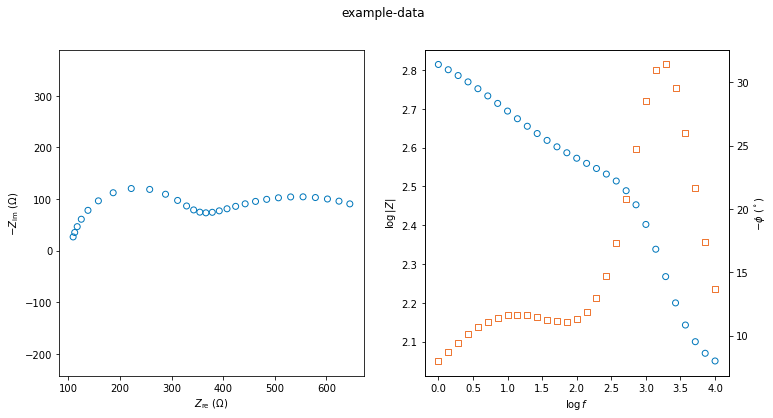

In [19]:
from cmath import rect
from json import load
from math import radians
from numpy import array
from os.path import basename, exists, splitext
from typing import IO


def parse_json(path: str) -> DataSet:
    assert exists(path), "Invalid path to data file!"
    fp: IO
    with open(path, "r") as fp:
        json: dict = load(fp)
    assert (
        "frequency" in json and type(json["frequency"]) is list
        and "magnitude" in json and type(json["magnitude"]) is list
        and "phase" in json and type(json["phase"]) is list
    ), "Invalid data structure!"
    frequency: ndarray = array(json["frequency"])  # Frequency (in hertz) of the excitation signal.
    magnitude: ndarray = array(json["magnitude"])  # Magnitude (or modulus) of the complex impedance.
    phase: ndarray = array(json["phase"])  # Argument of the complex impedance in degrees.
    # Turn the polar coordinate representation into a Cartesian coordinate representation
    # (1D numpy.array of complex numbers).
    impedance: ndarray = array(list(map(lambda z: rect(z[0], radians(z[1])), zip(magnitude, phase))))
    return DataSet(
        frequency,  # 1D numpy.array of frequencies in hertz
        impedance,  # 1D numpy.array of complex impedances
        path=path,  # Optional
        label=splitext(basename(path))[0],  # Optional
    )


project_ex3: Project = Project()
project_ex3.add_data_set(parse_json("example-data.json"))
for data in project_ex3.get_data_sets():
    fig, axes = mpl.plot_data(data)